In [1]:
import numpy as np
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from comchoice.preprocessing.to_pairwise import to_pairwise
from comchoice.aggregate import borda, divisiveness, win_rate
from glob import glob

In [2]:
year = 2022
country = "France"
location_level = "department"

In [3]:
df = pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gzip", compression="gzip")
df.columns = [x.lower() for x in df.columns]
df.head()

,polling_id,candidate,value,rank,rate
0,L'Abergement-Clémenciat-0001,Nathalie ARTHAUD,3,11,0.005769
1,L'Abergement-de-Varey-0001,Nathalie ARTHAUD,2,11,0.011696
2,Ambérieu-en-Bugey-0001,Nathalie ARTHAUD,4,12,0.004762
3,Ambérieu-en-Bugey-0002,Nathalie ARTHAUD,6,11,0.007126
4,Ambérieu-en-Bugey-0003,Nathalie ARTHAUD,8,11,0.008430


In [4]:
df_runoff = pd.read_csv(f"data_output/{country}/{year}_runoff.csv.gzip", compression="gzip")
df_runoff.columns = [x.lower() for x in df_runoff.columns]
df_runoff.head()

,polling_id,candidate,value,rank,rate
0,L'Abergement-Clémenciat-0001,Emmanuel MACRON,237,1,0.526667
1,L'Abergement-de-Varey-0001,Emmanuel MACRON,94,1,0.661972
2,Ambérieu-en-Bugey-0001,Emmanuel MACRON,360,1,0.503497
3,Ambérieu-en-Bugey-0002,Emmanuel MACRON,426,1,0.565737
4,Ambérieu-en-Bugey-0003,Emmanuel MACRON,449,1,0.559850


In [5]:
df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gzip", compression="gzip")
df_location.head()

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,department_id,department,circunscription_id,circunscription,commune_id,commune,polling_place,electors,abstentions,polling_id
0,01,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,0001,645,108,L'Abergement-Clémenciat-0001
1,01,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,0001,213,38,L'Abergement-de-Varey-0001
2,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0001,1129,266,Ambérieu-en-Bugey-0001
3,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0002,1128,265,Ambérieu-en-Bugey-0002
4,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0003,1213,246,Ambérieu-en-Bugey-0003


In [6]:
df1 = pd.merge(df, df_location[["polling_id", location_level]])

df1 = df1.groupby([location_level, "candidate"]).agg({"value": "sum"})
df1["rate"] = df1.groupby(level=[0]).apply(lambda x: x/x.sum())
df1 = df1.reset_index()

df2 = pd.merge(df_runoff, df_location[["polling_id", location_level]])

df2 = df2.groupby([location_level, "candidate"]).agg({"value": "sum"})
df2["rate"] = df2.groupby(level=[0]).apply(lambda x: x/x.sum())
df2 = df2.reset_index()

df_rounds = pd.merge(df1, df2, on=[location_level, "candidate"])
df_rounds["diff"] = df_rounds["rate_y"] - df_rounds["rate_x"]

In [7]:
df_rounds

,department,candidate,value_x,rate_x,value_y,rate_y,diff
0,Ain,Emmanuel MACRON,101995,0.275507,184107,0.546995,0.271488
1,Ain,Marine LE PEN,97323,0.262887,152472,0.453005,0.190118
2,Aisne,Emmanuel MACRON,73791,0.229678,129185,0.421548,0.191870
3,Aisne,Marine LE PEN,119862,0.373076,177269,0.578452,0.205376
4,Allier,Emmanuel MACRON,60575,0.265778,107560,0.523152,0.257374
...,...,...,...,...,...,...,...
209,Wallis et Futuna,Marine LE PEN,579,0.108043,1849,0.325528,0.217486
210,Yonne,Emmanuel MACRON,56444,0.246296,102874,0.491956,0.245660
211,Yonne,Marine LE PEN,69956,0.305257,106238,0.508044,0.202787
212,Yvelines,Emmanuel MACRON,250431,0.331719,473663,0.705643,0.373925


In [8]:
path = f"data_output/{country}/{year}_pairwise.csv.gzip"

if not os.path.isfile(path):

    df_pwc = to_pairwise(
        df,
        alternative="candidate",
        verbose=True,
        voter="polling_id"
    )
    df_pwc.to_csv(path, compression="gzip", index=False)
    
else: 
    df_pwc = pd.read_csv(path, compression="gzip")

In [9]:
data = pd.merge(df_location[[location_level, "polling_id"]].drop_duplicates(), df.copy(), on="polling_id").copy()

df_dv = data.groupby([location_level, "candidate"]).agg({"rank": "std"}).reset_index()\
    .rename(columns={"rank": "value", "candidate": "alternative"})

In [10]:
path = f"data_output/{country}/{year}_divisiveness_{location_level}.csv.gzip"

# if not os.path.isfile(path):

#     output = []

#     # location_level = "department"
#     data = pd.merge(df_location[[location_level, "polling_id"]].drop_duplicates(), df_pwc.copy(), on="polling_id").copy()
#     for i, tmp in data.groupby(location_level):
#         dv = divisiveness(
#             tmp,
#     #         method=borda,
#             voter="polling_id",
#             method_kws=dict(voter="polling_id")
#         )
#         dv[location_level] = i
#         output.append(dv)

#         print(i)


#     df_dv = pd.concat(output, ignore_index=True)
#     df_dv.to_csv(path, compression="gzip", index=False)
    
# else:
#     df_dv = pd.read_csv(path, compression="gzip")

df_dv.head()



,department,alternative,value
0,Ain,Anne HIDALGO,14.719493
1,Ain,Emmanuel MACRON,5.181713
2,Ain,Fabien ROUSSEL,12.998000
3,Ain,Jean LASSALLE,10.611335
4,Ain,Jean-Luc MÉLENCHON,6.308354


In [11]:
df_rounds

,department,candidate,value_x,rate_x,value_y,rate_y,diff
0,Ain,Emmanuel MACRON,101995,0.275507,184107,0.546995,0.271488
1,Ain,Marine LE PEN,97323,0.262887,152472,0.453005,0.190118
2,Aisne,Emmanuel MACRON,73791,0.229678,129185,0.421548,0.191870
3,Aisne,Marine LE PEN,119862,0.373076,177269,0.578452,0.205376
4,Allier,Emmanuel MACRON,60575,0.265778,107560,0.523152,0.257374
...,...,...,...,...,...,...,...
209,Wallis et Futuna,Marine LE PEN,579,0.108043,1849,0.325528,0.217486
210,Yonne,Emmanuel MACRON,56444,0.246296,102874,0.491956,0.245660
211,Yonne,Marine LE PEN,69956,0.305257,106238,0.508044,0.202787
212,Yvelines,Emmanuel MACRON,250431,0.331719,473663,0.705643,0.373925


In [12]:
df_test = pd.merge(df_rounds, df_dv, left_on=["candidate", location_level], right_on=["alternative", location_level])
df_test.head()

,department,candidate,value_x,rate_x,value_y,rate_y,diff,alternative,value
0,Ain,Emmanuel MACRON,101995,0.275507,184107,0.546995,0.271488,Emmanuel MACRON,5.181713
1,Ain,Marine LE PEN,97323,0.262887,152472,0.453005,0.190118,Marine LE PEN,4.883646
2,Aisne,Emmanuel MACRON,73791,0.229678,129185,0.421548,0.191870,Emmanuel MACRON,4.940071
3,Aisne,Marine LE PEN,119862,0.373076,177269,0.578452,0.205376,Marine LE PEN,4.303243
4,Allier,Emmanuel MACRON,60575,0.265778,107560,0.523152,0.257374,Emmanuel MACRON,6.641526


<Figure size 504x504 with 0 Axes>

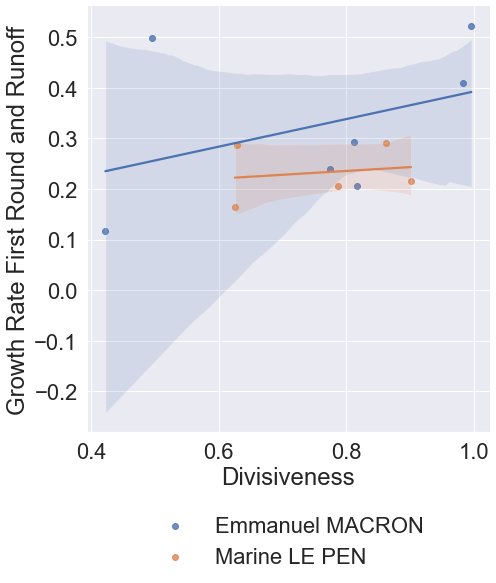

In [13]:
sns.set(font_scale=2)
plt.figure(figsize=(7, 7))

g = sns.lmplot(x="value", height=7, y="diff", hue="alternative", legend=False,
               data=df_test[(df_test["value"] > 0) & (df_test["value"] < 1)])
# g.set_xlabel("Divisiveness")
# g.set_ylabel("Growth Rate First Round and Runoff")

g.set_axis_labels("Divisiveness", "Growth Rate First Round and Runoff")
plt.legend(title="", loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=False, shadow=False, frameon=False, ncol=1)

# plt.xscale('log')
# plt.yscale('log')

In [14]:
candidates = df_rounds["candidate"].unique()
candidate_a = candidates[0]
candidate_b = candidates[1]

candidate_a, candidate_b

('Emmanuel MACRON', 'Marine LE PEN')

In [31]:
import statsmodels.api as sm

0      0.275507
1      0.229678
2      0.265778
3      0.249627
4      0.226869
         ...   
101    0.352296
102    0.289526
103    0.255073
104    0.246296
105    0.331719
Name: (rate_x, Emmanuel MACRON), Length: 106, dtype: float64

In [42]:


Y = ff[("rate_x", "Emmanuel MACRON")]
X = ff[df.candidate.unique()]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())

                                  OLS Regression Results                                 
Dep. Variable:     ('rate_x', 'Emmanuel MACRON')   R-squared:                       0.183
Model:                                       OLS   Adj. R-squared:                  0.078
Method:                            Least Squares   F-statistic:                     1.739
Date:                           Fri, 05 Aug 2022   Prob (F-statistic):             0.0707
Time:                                   01:44:51   Log-Likelihood:                 177.47
No. Observations:                            106   AIC:                            -328.9
Df Residuals:                                 93   BIC:                            -294.3
Df Model:                                     12                                         
Covariance Type:                       nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------

In [15]:
ee = df_dv.pivot(index=location_level, columns="alternative", values="value")
ee["diff_dv"] = ee[candidate_a] - ee[candidate_b]
ee = ee.reset_index().dropna()
ee = ee[ee["diff_dv"] != 0]
ee

alternative,department,Anne HIDALGO,Emmanuel MACRON,Fabien ROUSSEL,Jean LASSALLE,Jean-Luc MÉLENCHON,Marine LE PEN,Nathalie ARTHAUD,Nicolas DUPONT-AIGNAN,Philippe POUTOU,Valérie PÉCRESSE,Yannick JADOT,Éric ZEMMOUR,diff_dv
0,Ain,14.719493,5.181713,12.998000,10.611335,6.308354,4.883646,17.082221,13.581067,16.253752,10.361474,12.768956,10.422268,0.298067
1,Aisne,13.820728,4.940071,12.921721,10.254172,6.801716,4.303243,15.534605,12.734066,15.289001,10.854532,11.698157,9.802749,0.636829
2,Allier,17.713049,6.641526,16.659623,12.925582,8.789474,6.128993,19.952094,15.660240,19.354258,12.683562,15.584786,12.973643,0.512533
3,Alpes-Maritimes,5.096592,1.823218,4.527967,3.839548,1.916556,1.405276,5.160410,4.140486,5.834964,3.805276,4.326785,3.199944,0.417942
4,Alpes-de-Haute-Provence,12.939234,5.156832,13.380755,9.915858,5.142819,5.240845,14.580414,12.599818,14.572842,10.734004,11.991834,9.537020,-0.084013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Vendée,8.100337,2.887426,7.071549,6.165818,3.446670,2.771407,9.304062,6.883251,8.606556,5.607272,6.414966,5.193037,0.116019
102,Vienne,14.096948,4.679858,12.625717,9.222905,6.605384,4.380962,15.671412,12.459831,15.067123,9.804305,11.951961,9.696229,0.298896
103,Vosges,11.010403,4.153411,10.143822,8.550137,5.319451,3.653618,12.451884,10.147882,12.260343,8.633560,9.362651,7.906696,0.499794
105,Yonne,16.007820,5.835443,15.759553,12.085651,8.436189,6.096887,19.622073,15.964121,19.116153,12.964301,14.346335,12.379532,-0.261444


In [35]:
dd = df_rounds.pivot(index=location_level, columns="candidate", values=["rate_x", "rate_y"])
dd["sum"] = dd[("rate_x", candidate_a)] + dd[("rate_x", candidate_b)]
dd["diff"] = (dd[("rate_y", candidate_a)] - dd[("rate_y", candidate_b)]) -\
    (dd[("rate_x", candidate_a)]/dd["sum"] - dd[("rate_x", candidate_b)]/dd["sum"])
dd = dd.reset_index()
dd["var"] = 1 - (dd[("rate_x", candidate_a)] + dd[("rate_x", candidate_b)])
dd.head()

department          rate_x                \
candidate                          Emmanuel MACRON Marine LE PEN   
0                              Ain        0.275507      0.262887   
1                            Aisne        0.229678      0.373076   
2                           Allier        0.265778      0.271819   
3                  Alpes-Maritimes        0.249627      0.265718   
4          Alpes-de-Haute-Provence        0.226869      0.261221   

                   rate_y                     sum      diff       var  
candidate Emmanuel MACRON Marine LE PEN                                
0                0.546995      0.453005  0.538393  0.070550  0.461607  
1                0.421548      0.578452  0.602755  0.081000  0.397245  
2                0.523152      0.476848  0.537597  0.057542  0.462403  
3                0.501156      0.498844  0.515346  0.033536  0.484654  
4                0.500870      0.499130  0.488090  0.072119  0.511910

In [36]:
ff = pd.merge(dd.reset_index(), ee, on=location_level)
ff.head()

C:\Users\cnavarreteliz\AppData\Local\Temp\ipykernel_16428\1820468184.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  ff = pd.merge(dd.reset_index(), ee, on=location_level)


,department,"(index, )","(department, )","(rate_x, Emmanuel MACRON)","(rate_x, Marine LE PEN)","(rate_y, Emmanuel MACRON)","(rate_y, Marine LE PEN)","(sum, )","(diff, )","(var, )",...,Jean LASSALLE,Jean-Luc MÉLENCHON,Marine LE PEN,Nathalie ARTHAUD,Nicolas DUPONT-AIGNAN,Philippe POUTOU,Valérie PÉCRESSE,Yannick JADOT,Éric ZEMMOUR,diff_dv
0,Ain,0,Ain,0.275507,0.262887,0.546995,0.453005,0.538393,0.070550,0.461607,...,10.611335,6.308354,4.883646,17.082221,13.581067,16.253752,10.361474,12.768956,10.422268,0.298067
1,Aisne,1,Aisne,0.229678,0.373076,0.421548,0.578452,0.602755,0.081000,0.397245,...,10.254172,6.801716,4.303243,15.534605,12.734066,15.289001,10.854532,11.698157,9.802749,0.636829
2,Allier,2,Allier,0.265778,0.271819,0.523152,0.476848,0.537597,0.057542,0.462403,...,12.925582,8.789474,6.128993,19.952094,15.660240,19.354258,12.683562,15.584786,12.973643,0.512533
3,Alpes-Maritimes,3,Alpes-Maritimes,0.249627,0.265718,0.501156,0.498844,0.515346,0.033536,0.484654,...,3.839548,1.916556,1.405276,5.160410,4.140486,5.834964,3.805276,4.326785,3.199944,0.417942
4,Alpes-de-Haute-Provence,4,Alpes-de-Haute-Provence,0.226869,0.261221,0.500870,0.499130,0.488090,0.072119,0.511910,...,9.915858,5.142819,5.240845,14.580414,12.599818,14.572842,10.734004,11.991834,9.537020,-0.084013


In [18]:
candidate_a, candidate_b

('Emmanuel MACRON', 'Marine LE PEN')

In [19]:
import numpy as np

<AxesSubplot:xlabel='diff_dv', ylabel='diff'>

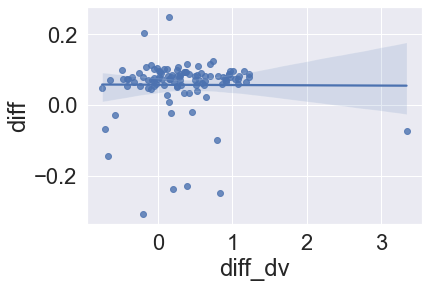

In [20]:
ff.columns = ["dep", "in", "department", "diff", "var", "diff_dv"]
# ff["diff"] = np.abs(ff["diff"])
# ff["diff_dv"] = np.abs(ff["diff_dv"])
# ff["diff_dv"]
sns.regplot(x="diff_dv", y="diff", data=ff)

<AxesSubplot:xlabel='var', ylabel='diff'>

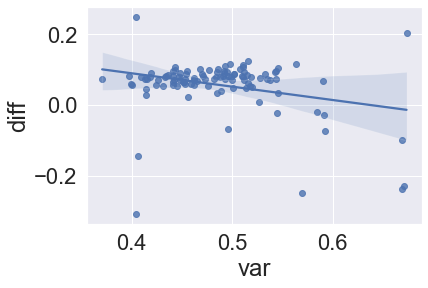

In [21]:
sns.regplot(x="var", y="diff", data=ff)

In [22]:
len(df.candidate.unique())

12

In [23]:
# gdf = gpd.read_file("https://raw.githubusercontent.com/fcortes/Chile-GeoJSON/master/regiones_edit.geojson")
# gdf.head()

In [24]:
# tmp = pd.merge(gdf, df_dv, left_on="Region", right_on="region")
# tmp = tmp[tmp["alternative"] == "FRANCO PARISI FERNANDEZ"]

In [25]:
# fig, ax = plt.subplots(figsize=(4, 20))
# tmp.plot(column="value", ax=ax, legend=True)

In [27]:
ff

,dep,in,department,diff,var,diff_dv
0,Ain,0,Ain,0.070550,0.461607,0.298067
1,Aisne,1,Aisne,0.081000,0.397245,0.636829
2,Allier,2,Allier,0.057542,0.462403,0.512533
3,Alpes-Maritimes,3,Alpes-Maritimes,0.033536,0.484654,0.417942
4,Alpes-de-Haute-Provence,4,Alpes-de-Haute-Provence,0.072119,0.511910,-0.084013
...,...,...,...,...,...,...
101,Vendée,101,Vendée,0.027330,0.413957,0.116019
102,Vienne,102,Vienne,0.087124,0.469539,0.298896
103,Vosges,103,Vosges,0.071569,0.425721,0.499794
104,Yonne,105,Yonne,0.090812,0.448447,-0.261444
